## 0. Abstract

- 대상 : 오프라인 매장을 운영하는 유통업체(B2C)
- 사용자 : 매장직원
- 목표 : 제품 사진 촬영 시, 해당 제품을 인식하고 정보를 불러옴
- 환경 : 제휴 논의 단계로 제공받은 데이터가 없는 상황에서 프로토타입 모델 제작이 필요

## 1. Import libraries

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import confusion_matrix, classification_report

import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


import warnings
warnings.filterwarnings('ignore')

## 2. Collect data

- 대상 업체로부터 제공받은 데이터가 없으므로 수작업으로 이미지셋을 제작, 브라우저 확장프로그램으로 해당 브랜드의 제품군별로 이미지를 저장
- 5개 제품군(Jacket, Skirt, T-shirt, Polo-shirt, Shoes) 총 1200개 이미지
- 폴더트리 : train/test 별 각 5개 폴더

<img src="files/image/image_recognition_1.png">

## 3. Load data with data augmentation

- 데이터의 양이 매우 적은 상황이므로 data augmentation 활용

In [387]:
# Get train data and its augmented data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15, #randomly rotate images in 0~15 degrees
                                   width_shift_range=0.1, #randomly translate images
                                   height_shift_range=0.1, #randomly translate images
                                   shear_range=0.1, #applying shearing
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'd://image//train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical') #multi-class classification

# get test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'd://image//test',
        target_size=(150, 150),    
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

Found 873 images belonging to 5 classes.
Found 305 images belonging to 5 classes.


## 4. Define first model

- Fine-turning 이전, 간단한 모델을 만들고 성능을 평가
- 첫번째 모델은 높은 수준의 overfitting을 보여줌

In [58]:
model = Sequential() # linear stacks of layers

### first layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))


### shrink dimensions of the previous layer to solve over-fitting problem
model.add(MaxPooling2D(pool_size=(2, 2)))

### second layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### third layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
       
### fourth layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### Convert it to 1-dimension tensor (ventor) + dropout for handling overfitting
model.add(Flatten())
model.add(Dropout(0.5))
# fourth layer
model.add(Dense(512, activation='relu'))

# Output layer, it returns probabilities of samples being each class(there are 5 classes)
model.add(Dense(5, activation='softmax'))

In [59]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

In [60]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=50)

Epoch 1/50
100/100 [==============================] - 426s 4s/step - loss: 1.5676 - acc: 0.2399 - val_loss: 1.5708 - val_acc: 0.2911
Epoch 2/50
100/100 [==============================] - 416s 4s/step - loss: 1.5336 - acc: 0.3092 - val_loss: 1.5310 - val_acc: 0.3414
Epoch 3/50
100/100 [==============================] - 413s 4s/step - loss: 1.4721 - acc: 0.3532 - val_loss: 1.4703 - val_acc: 0.3560
Epoch 4/50
100/100 [==============================] - 420s 4s/step - loss: 1.4326 - acc: 0.3910 - val_loss: 1.4895 - val_acc: 0.3812
Epoch 5/50
100/100 [==============================] - 454s 5s/step - loss: 1.3781 - acc: 0.4104 - val_loss: 1.4110 - val_acc: 0.3780
Epoch 6/50
100/100 [==============================] - 467s 5s/step - loss: 1.3315 - acc: 0.4634 - val_loss: 1.4663 - val_acc: 0.3340
Epoch 7/50
100/100 [==============================] - 440s 4s/step - loss: 1.3001 - acc: 0.4613 - val_loss: 1.4347 - val_acc: 0.3581
Epoch 8/50
100/100 [==============================] - 457s 5s/step - 

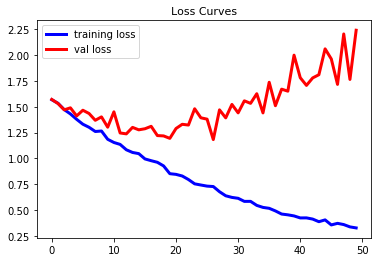

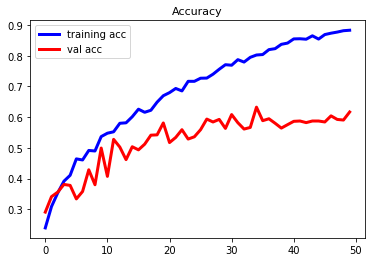

Training acc: 0.8827
val acc: 0.6168


In [62]:
#Plot the Loss Curves and accuracy

plt.plot(history.history['loss'],'b',linewidth=3.0, label='training loss')
plt.plot(history.history['val_loss'],'r',linewidth=3.0, label='val loss')
plt.title('Loss Curves',fontsize=11)
plt.legend()

plt.figure()
plt.plot(history.history['acc'],'b',linewidth=3.0, label='training acc')
plt.plot(history.history['val_acc'],'r',linewidth=3.0, label='val acc')
plt.title('Accuracy',fontsize=11)
plt.legend()
plt.show()

print("Training acc: {:.4f}".format(history.history['acc'][-1]))
print("val acc: {:.4f}".format(history.history['val_acc'][-1]))

In [63]:
model.save('five_class_classifier_1.h5')

- overfitting에 대응하기 위해 train set의 양을 증가시키거나 모형을 단순화하여야 함.
- train set의 양을 늘리는 건 현재 business 단계에 큰 의미가 없음
- 모형을 단순화하기 전, pre-trained model을 부착하여 개선이 가능한 지 검토

## 5. Add a pre-trained convet model with augmentation

- Imagenet 데이터를 학습한 resnet model을 overfitting을 더 가중시킬 뿐 문제 해결에 도움을 주진 못함

In [114]:
from keras.applications import resnet50

resnet_model = resnet50.ResNet50(weights='imagenet', 
                                 include_top=False, #without classifier layers                     
                                 input_shape=(150, 150, 3))

94658560/94653016 [==============================] - 20s 0us/step


In [130]:
resnet_model.summary()
# (None, 5, 5, 2048) : top layer의 dimension

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [153]:
train_sample_cnt = len(train_generator.classes)
test_sample_cnt = len(test_generator.classes)
print(train_sample_cnt)

873


In [194]:
# Get train data and its augmented data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15, #randomly rotate images in 0~15 degrees
                                   width_shift_range=0.1, #randomly translate images
                                   height_shift_range=0.1, #randomly translate images
                                   shear_range=0.1, #applying shearing
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'd://image//train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical') #multi-class classification

# get test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'd://image//test',
        target_size=(150, 150),    
        batch_size=20,
        class_mode='categorical')

# build a model
model_w_pretrained_drop = Sequential()
model_w_pretrained_drop.add(resnet_model)
model_w_pretrained_drop.add(Flatten())
model_w_pretrained_drop.add(Dropout(.5))
model_w_pretrained_drop.add(Dense(256, activation='relu'))
model_w_pretrained_drop.add(Dense(5, activation='softmax'))

resnet_model.trainable=False # freezing pre-trained layers

model_w_pretrained_drop.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
history = model_w_pretrained_drop.fit_generator(train_generator,
                                                steps_per_epoch=100,
                                                epochs=50,
                                                validation_data=test_generator,
                                                validation_steps=50)

Found 873 images belonging to 5 classes.
Found 305 images belonging to 5 classes.


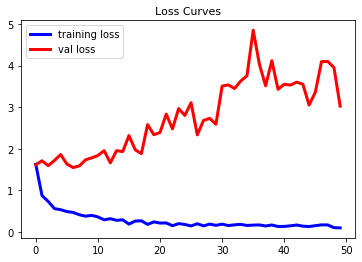

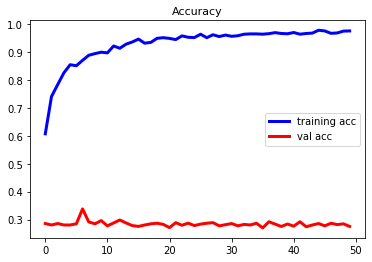

Training acc: 0.9748
val acc: 0.2754


In [197]:
#Plot the Loss Curves and accuracy

plt.plot(history.history['loss'],'b',linewidth=3.0, label='training loss')
plt.plot(history.history['val_loss'],'r',linewidth=3.0, label='val loss')
plt.title('Loss Curves',fontsize=11)
plt.legend()

plt.figure()
plt.plot(history.history['acc'],'b',linewidth=3.0, label='training acc')
plt.plot(history.history['val_acc'],'r',linewidth=3.0, label='val acc')
plt.title('Accuracy',fontsize=11)
plt.legend()
plt.show()

print("Training acc: {:.4f}".format(history.history['acc'][-1]))
print("val acc: {:.4f}".format(history.history['val_acc'][-1]))

## 6. Final model

In [216]:
model_f = Sequential() # linear stacks of layers
model_f.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3))) ### first layer
model_f.add(MaxPooling2D(pool_size=(2, 2))) ### shrink dimensions of the previous layer to solve over-fitting problem
model_f.add(Conv2D(128, (3, 3), activation='relu'))
model_f.add(Conv2D(128, (3, 3), activation='relu'))
model_f.add(Conv2D(128, (3, 3), activation='relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Conv2D(256, (3, 3), activation='relu'))
model_f.add(Conv2D(256, (3, 3), activation='relu'))
model_f.add(Conv2D(256, (3, 3), activation='relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Conv2D(512, (3, 3), activation='relu'))
model_f.add(Conv2D(512, (3, 3), activation='relu'))
model_f.add(Conv2D(512, (3, 3), activation='relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Flatten())
model_f.add(Dropout(0.5))
model_f.add(Dense(512, activation='relu'))
model_f.add(Dense(5, activation='softmax'))

model_f.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

history_final = model_f.fit_generator(train_generator,
                                      steps_per_epoch=100,
                                      epochs=30,
                                      validation_data=test_generator,
                                      validation_steps=30)

Epoch 1/30
100/100 [==============================] - 483s 5s/step - loss: 1.5658 - acc: 0.2559 - val_loss: 1.5849 - val_acc: 0.1316
Epoch 2/30
100/100 [==============================] - 477s 5s/step - loss: 1.5558 - acc: 0.2739 - val_loss: 1.5643 - val_acc: 0.2982
Epoch 3/30
100/100 [==============================] - 487s 5s/step - loss: 1.5247 - acc: 0.3151 - val_loss: 1.5388 - val_acc: 0.3175
Epoch 4/30
100/100 [==============================] - 470s 5s/step - loss: 1.4804 - acc: 0.3490 - val_loss: 1.5069 - val_acc: 0.3140
Epoch 5/30
100/100 [==============================] - 478s 5s/step - loss: 1.4296 - acc: 0.3873 - val_loss: 1.5981 - val_acc: 0.3702
Epoch 6/30
100/100 [==============================] - 473s 5s/step - loss: 1.4110 - acc: 0.4219 - val_loss: 1.4409 - val_acc: 0.4018
Epoch 7/30
100/100 [==============================] - 481s 5s/step - loss: 1.3549 - acc: 0.4482 - val_loss: 1.6933 - val_acc: 0.2838
Epoch 8/30
100/100 [==============================] - 485s 5s/step - 

--Image and predicted label--


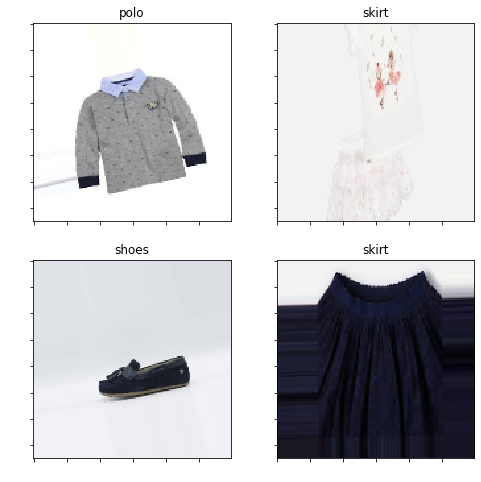

In [361]:
x, y = train_generator.next()
pred_label = np.argmax(model_f.predict(x), axis=1)
product_label = {0: 'jacket', 1: 'polo', 2: 'shoes', 3: 'skirt', 4: 'tshirt'}
pred_plot = [product_label[i] for i in list(pred_label)]


plt.figure(figsize=(8, 8))
print('--Image and predicted label--')
for i in range(1, 5):
    image = x[i]
    plt.subplot(2, 2, i)
    plt.imshow(image)
    plt.title(pred_plot[i])
    plt.xticks(color='w')
    plt.yticks(color='w')

plt.show()

In [378]:
model_f.save('five_class_classifier_3.h5')

## 7. Diagnose misclassification

- polo, t-shirt 제품군은 중첩되는 특징이 많아 FN 오류가 발생
- skirt의 경우 특히 모델이 착용한 사진이 다수 포함되어 있어 학습에 어려움이 존재
- 모델이 착용하지 않은 제품만 있는 사진으로 학습시킬 경우, 적은 이미지양으로도 70% 이상의 accuracy가 확보될 것으로 기대

In [389]:
y_pred_prob = model_f.predict_generator(test_generator, 16)
y_pred = np.argmax(y_pred_prob, axis=1)
print(len(y_pred), len(test_generator.classes))

305 305


In [396]:
print('--Confusion matrix and report--\n')

print(confusion_matrix(test_generator.classes, y_pred), '\n')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices))

--Confusion matrix and report--

[[50 21  2 12  5]
 [ 5 39  0  5  6]
 [ 9 15 35 18  9]
 [ 6  2  1 34  0]
 [ 2  6  5  4 14]] 

              precision    recall  f1-score   support

      jacket       0.69      0.56      0.62        90
        polo       0.47      0.71      0.57        55
       shoes       0.81      0.41      0.54        86
       skirt       0.47      0.79      0.59        43
      tshirt       0.41      0.45      0.43        31

    accuracy                           0.56       305
   macro avg       0.57      0.58      0.55       305
weighted avg       0.63      0.56      0.56       305

